In [7]:
# ============================================================
# 1. Kaggle API setup (using your personal token)
# ============================================================

import json
import os

# =============================================================
# IMPORTANT — TODO:
# Replace the value below with YOUR OWN Kaggle token string.
#
# Please read the README file for step-by-step instructions
# on how to get your Kaggle token from your profile settings.
# =============================================================
api_token = "YOUR_KAGGLE_TOKEN_HERE"

# Create kaggle.json content for the Kaggle CLI
token_data = {
    "username": "",     # username can be left blank for new token style
    "key": api_token
}

# Create ~/.kaggle folder if it doesn't exist
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Save kaggle.json
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(token_data, f)

# Set correct permissions
!chmod 600 ~/.kaggle/kaggle.json

print("kaggle.json created successfully!")



kaggle.json created successfully!


In [8]:
# ============================================================
# 2. Download and unzip the Natural Images dataset
# ============================================================

# Download the dataset from Kaggle
!kaggle datasets download -d prasunroy/natural-images

# Unzip into ./data
!unzip -q natural-images.zip -d ./data

# Check that the class folders exist
!ls ./data/data/natural_images

Dataset URL: https://www.kaggle.com/datasets/prasunroy/natural-images
License(s): CC-BY-NC-SA-4.0
natural-images.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./data/data/natural_images/airplane/airplane_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
airplane  car  cat  dog  flower  fruit	motorbike  person


In [9]:
# ============================================================
# 3. Data loading and preprocessing (ImageDataGenerator)
# ============================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the dataset root directory (contains 8 class folders)
data_dir = "./data/data/natural_images"

img_height, img_width = 224, 224   # standard size for ResNet50
batch_size = 16                    # smaller batch size to fit in T4 GPU memory

# Data augmentation + rescaling. validation_split = 0.2 => 80% train, 20% val
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
)

# Training subset
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation subset
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)


Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.
Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Number of classes: 8


In [10]:
# ============================================================
# 4. Build ResNet50 transfer-learning model (Stage 1: frozen)
# ============================================================

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 (ImageNet weights, no classifier head)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Stage 1: freeze all convolutional layers (feature extractor)
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head for 8 classes
x = base_model.output
x = GlobalAveragePooling2D()(x)        # global pooling instead of Flatten
x = Dropout(0.5)(x)                    # regularization
x = Dense(256, activation='relu')(x)   # fully-connected layer
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile with slightly higher learning rate for the new head
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
# ============================================================
# 5. Train the model (Stage 1) + fine-tuning (Stage 2)
# ============================================================

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 5.1 Stage 1: train only the new classification head
epochs_stage1 = 10
checkpoint_path = "resnet_natural_images_best.h5"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

print("=== Stage 1: training with frozen base model ===")
history = model.fit(
    train_generator,
    epochs=epochs_stage1,
    validation_data=val_generator,
    callbacks=callbacks
)

# 5.2 Stage 2: fine-tune the top layers of ResNet50
# Unfreeze the last convolutional block(s) for better accuracy
fine_tune_at = 140   # layer index to start unfreezing (can be adjusted)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Use a smaller learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

epochs_stage2 = 5

print("=== Stage 2: fine-tuning top ResNet layers ===")
history_fine = model.fit(
    train_generator,
    epochs=epochs_stage2,
    validation_data=val_generator,
    callbacks=callbacks
)

# ------------------------------------------------------------
# Combine Stage 1 + Stage 2 history so plots show all epochs
# ------------------------------------------------------------
total_accuracy = history.history['accuracy'] + history_fine.history['accuracy']
total_val_accuracy = history.history['val_accuracy'] + history_fine.history['val_accuracy']

total_loss = history.history['loss'] + history_fine.history['loss']
total_val_loss = history.history['val_loss'] + history_fine.history['val_loss']



=== Stage 1: training with frozen base model ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.1811 - loss: 2.2531

346/346 ━━━━━━━━━━━━━━━━━━━━ 120s 308ms/step - accuracy: 0.1812 - loss: 2.2525 - val_accuracy: 0.3224 - val_loss: 1.7574
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.2766 - loss: 1.8279

346/346 ━━━━━━━━━━━━━━━━━━━━ 91s 263ms/step - accuracy: 0.2767 - loss: 1.8278 - val_accuracy: 0.3471 - val_loss: 1.6859
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.3145 - loss: 1.7409

346/346 ━━━━━━━━━━━━━━━━━━━━ 91s 262ms/step - accuracy: 0.3146 - loss: 1.7409 - val_accuracy: 0.4321 - val_loss: 1.6147
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3334 - loss: 1.6937

346/346 ━━━━━━━━━━━━━━━━━━━━ 92s 266ms/step - accuracy: 0.3335 - loss: 1.6936 - val_accuracy: 0.4365 - val_loss: 1.5800
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3488 - loss: 1.6442

346/346 ━━━━━━━━━━━━━━━━━━━━ 91s 262ms/step - accuracy: 0.3489 - loss: 1.6441 - val_accuracy: 0.4793 - val_loss: 1.4988
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3715 - loss: 1.6191

346/346 ━━━━━━━━━━━━━━━━━━━━ 90s 261ms/step - accuracy: 0.3715 - loss: 1.6190 - val_accuracy: 0.4546 - val_loss: 1.4940
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3884 - loss: 1.5946

346/346 ━━━━━━━━━━━━━━━━━━━━ 92s 266ms/step - accuracy: 0.3885 - loss: 1.5945 - val_accuracy: 0.4902 - val_loss: 1.4355
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 91s 263ms/step - accuracy: 0.3995 - loss: 1.5477 - val_accuracy: 0.4379 - val_loss: 1.4739
Epoch 9/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 91s 264ms/step - accuracy: 0.4050 - loss: 1.5373 - val_accuracy: 0.4858 - val_loss: 1.4518
Epoch 10/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4082 - loss: 1.5244

346/346 ━━━━━━━━━━━━━━━━━━━━ 91s 262ms/step - accuracy: 0.4082 - loss: 1.5244 - val_accuracy: 0.4713 - val_loss: 1.4105
=== Stage 2: fine-tuning top ResNet layers ===
Epoch 1/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.3714 - loss: 3.3096

346/346 ━━━━━━━━━━━━━━━━━━━━ 128s 314ms/step - accuracy: 0.3716 - loss: 3.3053 - val_accuracy: 0.5781 - val_loss: 1.1404
Epoch 2/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 95s 273ms/step - accuracy: 0.5569 - loss: 1.2383 - val_accuracy: 0.4691 - val_loss: 1.5657
Epoch 3/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6028 - loss: 1.0776

346/346 ━━━━━━━━━━━━━━━━━━━━ 95s 276ms/step - accuracy: 0.6029 - loss: 1.0774 - val_accuracy: 0.6369 - val_loss: 1.0665
Epoch 4/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6579 - loss: 0.9142

346/346 ━━━━━━━━━━━━━━━━━━━━ 95s 274ms/step - accuracy: 0.6580 - loss: 0.9142 - val_accuracy: 0.7386 - val_loss: 0.7478
Epoch 5/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 93s 270ms/step - accuracy: 0.6960 - loss: 0.8330 - val_accuracy: 0.6093 - val_loss: 1.2595


87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 223ms/step - accuracy: 0.6877 - loss: 0.8907
Final validation loss: 0.7450700998306274
Final validation accuracy: 0.7254902124404907
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step
Classification report:
              precision    recall  f1-score   support

    airplane       0.86      0.61      0.72       145
         car       0.63      0.94      0.76       193
         cat       0.48      0.63      0.54       177
         dog       0.44      0.30      0.36       140
      flower       0.71      0.71      0.71       168
       fruit       0.98      0.88      0.93       200
   motorbike       0.96      0.73      0.83       157
      person       0.91      0.88      0.89       197

    accuracy                           0.73      1377
   macro avg       0.75      0.71      0.72      1377
weighted avg       0.75      0.73      0.73      1377



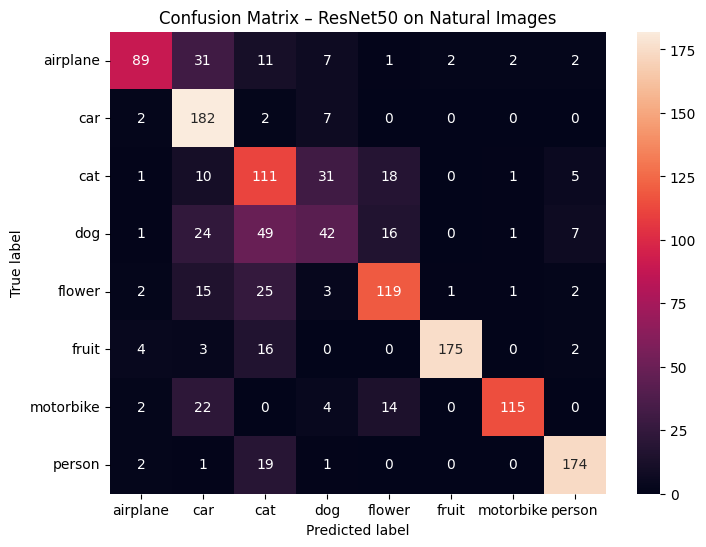

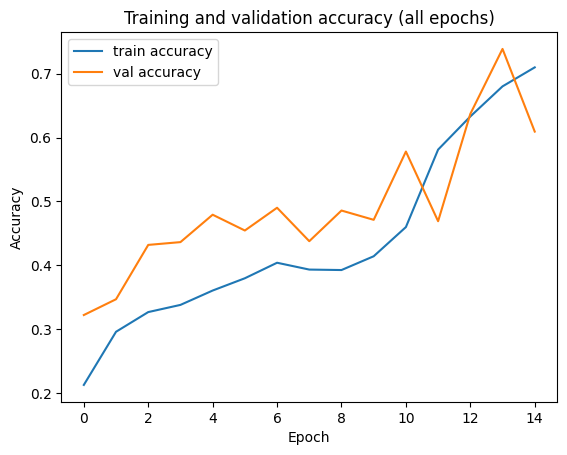

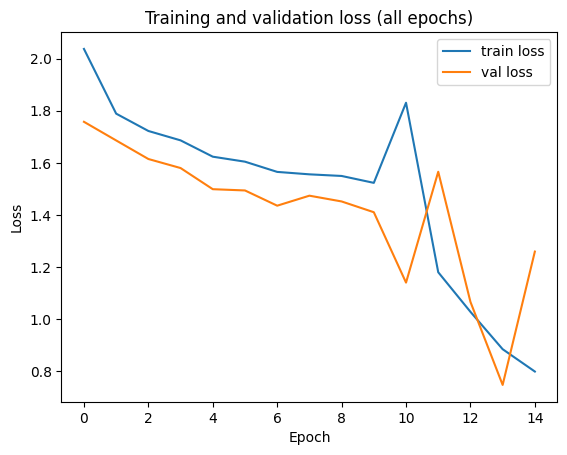

Model saved as resnet_natural_images_final.h5


In [12]:
# ============================================================
# 6. Evaluation: metrics, confusion matrix, curves, save model
# ============================================================

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Final evaluation on validation set (after fine-tuning)
val_loss, val_acc = model.evaluate(val_generator)
print("Final validation loss:", val_loss)
print("Final validation accuracy:", val_acc)

# Reset generator to start from first image
val_generator.reset()

# Predicted probabilities and classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = val_generator.classes

# Classification report (precision, recall, F1)
print("Classification report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – ResNet50 on Natural Images")
plt.show()

# Training/validation curves for ALL epochs (Stage 1 + Stage 2)
plt.figure()
plt.plot(total_accuracy, label='train accuracy')
plt.plot(total_val_accuracy, label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and validation accuracy (all epochs)')
plt.show()

plt.figure()
plt.plot(total_loss, label='train loss')
plt.plot(total_val_loss, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss (all epochs)')
plt.show()

# Save final fine-tuned model
model.save("resnet_natural_images_final.h5")
print("Model saved as resnet_natural_images_final.h5")